## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
from torch.utils.data.sampler import SubsetRandomSampler

import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
from imp import reload 
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *
# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
#torch.manual_seed(seed)
#np.random.seed(seed)

### Data load & Normalizations & Dataset for training

In [4]:
field   = "T"
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
aparams = np.loadtxt(fparam)
aparams = aparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams, aparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_{}_for_vib_total.npy".format(field))
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_{}_for_vib_total.npy".format(field))
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_{}_for_vib_total.npy".format(field))
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg, acoef_avg]
print(coef.shape, params.shape)

batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

/tmp/ipykernel_601593/1617029274.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/1617029274.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(3000, 513) (3000, 2)


/tmp/ipykernel_601593/1617029274.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


### Training VIB

In [5]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:307: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 6.4340... Accuracy: 0.0039... Test Om: 0.419 sig: 0.144
Epoch: 200/3000... Loss: 6.4318... Accuracy: 0.0035... Test Om: 0.287 sig: 0.123
Epoch: 300/3000... Loss: 6.4298... Accuracy: 0.0032... Test Om: 0.272 sig: 0.111
Epoch: 400/3000... Loss: 6.4284... Accuracy: 0.0029... Test Om: 0.267 sig: 0.103
Epoch: 500/3000... Loss: 6.4274... Accuracy: 0.0028... Test Om: 0.237 sig: 0.104
Epoch: 600/3000... Loss: 6.4268... Accuracy: 0.0027... Test Om: 0.242 sig: 0.102
Epoch: 700/3000... Loss: 6.4266... Accuracy: 0.0027... Test Om: 0.231 sig: 0.103
Epoch: 800/3000... Loss: 6.4260... Accuracy: 0.0026... Test Om: 0.233 sig: 0.101
Epoch: 900/3000... Loss: 6.4256... Accuracy: 0.0026... Test Om: 0.241 sig: 0.103
Epoch: 1000/3000... Loss: 6.4252... Accuracy: 0.0025... Test Om: 0.236 sig: 0.103
Epoch: 1100/3000... Loss: 6.4249... Accuracy: 0.0025... Test Om: 0.248 sig: 0.101
Epoch: 1200/3000... Loss: 6.4247... Accuracy: 0.0024... Test Om: 0.248 sig: 0.103
Epoch: 1300/3000... Loss:

In [13]:
field   = "Mgas"
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,2:4] ## only Om and Sig8
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,2:4] ## only Om and Sig8
params  = np.r_[gparams, rparams]
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
aparams = np.loadtxt(fparam)
aparams = aparams[:,2:4] ## only Om and Sig8
params  = np.r_[gparams, rparams]#, aparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_{}_for_vib_total.npy".format(field))
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_{}_for_vib_total.npy".format(field))
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_{}_for_vib_total.npy".format(field))
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]#, acoef_avg]
print(coef.shape, params.shape)

batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(gparams,dtype=torch.float)
X = torch.tensor(np.absolute(gcoef_avg),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_601593/410952287.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/410952287.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/410952287.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(2000, 513) (2000, 2)
Epoch: 100/3000... Loss: 7.6644... Accuracy: 0.0133... Test Om: 0.499 sig: 1.209
Epoch: 200/3000... Loss: 7.6388... Accuracy: 0.0131... Test Om: 0.393 sig: 1.220
Epoch: 300/3000... Loss: 7.6187... Accuracy: 0.0136... Test Om: 0.604 sig: 1.223
Epoch: 400/3000... Loss: 7.4804... Accuracy: 0.0124... Test Om: 0.379 sig: 1.179
Epoch: 500/3000... Loss: 7.3765... Accuracy: 0.0110... Test Om: 0.489 sig: 1.338
Epoch: 600/3000... Loss: 7.1794... Accuracy: 0.0094... Test Om: 0.354 sig: 1.214
Epoch: 700/3000... Loss: 6.9987... Accuracy: 0.0080... Test Om: 0.382 sig: 0.994
Epoch: 800/3000... Loss: 6.8628... Accuracy: 0.0071... Test Om: 0.399 sig: 1.404
Epoch: 900/3000... Loss: 6.7235... Accuracy: 0.0058... Test Om: 0.416 sig: 1.325
Epoch: 1000/3000... Loss: 6.6765... Accuracy: 0.0056... Test Om: 0.397 sig: 1.196
Epoch: 1100/3000... Loss: 6.6320... Accuracy: 0.0051... Test Om: 0.404 sig: 1.256
Epoch: 1200/3000... Loss: 6.5995... Accuracy: 0.0047... Test Om: 0.407 sig: 1.272
Epo

In [14]:
field   = "Mstar"
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,2:4] ## only Om and Sig8
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,2:4] ## only Om and Sig8
params  = np.r_[gparams, rparams]
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
aparams = np.loadtxt(fparam)
aparams = aparams[:,2:4] ## only Om and Sig8
params  = np.r_[gparams, rparams]#, aparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_{}_for_vib_total.npy".format(field))
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_{}_for_vib_total.npy".format(field))
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_{}_for_vib_total.npy".format(field))
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]#, acoef_avg]
print(coef.shape, params.shape)

batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(gparams,dtype=torch.float)
X = torch.tensor(np.absolute(gcoef_avg),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_601593/140183694.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/140183694.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/140183694.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(2000, 513) (2000, 2)
Epoch: 100/3000... Loss: 7.7004... Accuracy: 0.0140... Test Om: 0.663 sig: 1.164
Epoch: 200/3000... Loss: 7.6513... Accuracy: 0.0135... Test Om: 0.646 sig: 1.218
Epoch: 300/3000... Loss: 7.5490... Accuracy: 0.0123... Test Om: 0.414 sig: 1.257
Epoch: 400/3000... Loss: 7.5019... Accuracy: 0.0118... Test Om: 0.383 sig: 1.282
Epoch: 500/3000... Loss: 7.4405... Accuracy: 0.0118... Test Om: 0.423 sig: 1.211
Epoch: 600/3000... Loss: 7.4022... Accuracy: 0.0111... Test Om: 0.407 sig: 1.364
Epoch: 700/3000... Loss: 7.2821... Accuracy: 0.0100... Test Om: 0.349 sig: 1.407
Epoch: 800/3000... Loss: 7.1800... Accuracy: 0.0098... Test Om: 0.357 sig: 1.139
Epoch: 900/3000... Loss: 7.0953... Accuracy: 0.0087... Test Om: 0.412 sig: 1.408
Epoch: 1000/3000... Loss: 6.9887... Accuracy: 0.0081... Test Om: 0.394 sig: 1.293
Epoch: 1100/3000... Loss: 6.9416... Accuracy: 0.0081... Test Om: 0.391 sig: 1.219
Epoch: 1200/3000... Loss: 6.9016... Accuracy: 0.0073... Test Om: 0.441 sig: 1.360
Epo

In [12]:
field   = "Mgas"
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,2:4] ## only Om and Sig8
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,2:4] ## only Om and Sig8
params  = np.r_[gparams, rparams]
fparam  = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
aparams = np.loadtxt(fparam)
aparams = aparams[:,2:4] ## only Om and Sig8
params  = np.r_[gparams, rparams]#, aparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_{}_for_vib_total.npy".format(field))
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_{}_for_vib_total.npy".format(field))
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_{}_for_vib_total.npy".format(field))
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]#, acoef_avg]
print(coef.shape, params.shape)

batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_601593/1781653369.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/1781653369.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_601593/1781653369.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(2000, 513) (2000, 2)


/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:307: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 7.6436... Accuracy: 0.0133... Test Om: 0.707 sig: 1.208
Epoch: 200/3000... Loss: 7.3629... Accuracy: 0.0105... Test Om: 0.477 sig: 0.943
Epoch: 300/3000... Loss: 7.2916... Accuracy: 0.0099... Test Om: 0.565 sig: 0.860
Epoch: 400/3000... Loss: 7.1303... Accuracy: 0.0090... Test Om: 0.393 sig: 0.832
Epoch: 500/3000... Loss: 6.9580... Accuracy: 0.0077... Test Om: 0.420 sig: 0.820
Epoch: 600/3000... Loss: 6.8327... Accuracy: 0.0067... Test Om: 0.381 sig: 0.901
Epoch: 700/3000... Loss: 6.7067... Accuracy: 0.0058... Test Om: 0.447 sig: 0.981
Epoch: 800/3000... Loss: 6.6703... Accuracy: 0.0055... Test Om: 0.404 sig: 0.946
Epoch: 900/3000... Loss: 6.6129... Accuracy: 0.0049... Test Om: 0.401 sig: 0.947
Epoch: 1000/3000... Loss: 6.5838... Accuracy: 0.0046... Test Om: 0.423 sig: 1.031
Epoch: 1100/3000... Loss: 6.5650... Accuracy: 0.0044... Test Om: 0.417 sig: 0.968
Epoch: 1200/3000... Loss: 6.5528... Accuracy: 0.0042... Test Om: 0.415 sig: 0.998
Epoch: 1300/3000... Loss:

### Bias Test

tensor(-0.0132)
tensor(0.0093)
tensor(0.0802) 0.9299742711248239
tensor(0.0541) 0.7511765357574725
tensor(-0.1241)
tensor(-0.0146)
tensor(0.2787) 0.39326435806877535
tensor(0.1042) 0.2546140705172203


/tmp/ipykernel_601593/1883523457.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
/tmp/ipykernel_601593/1883523457.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


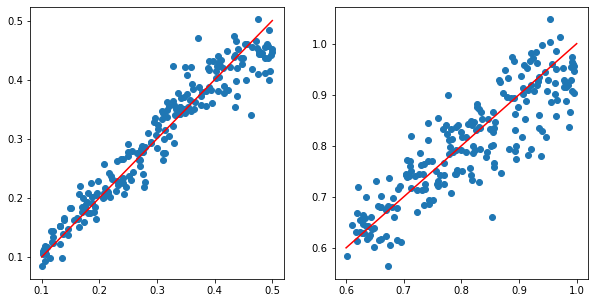

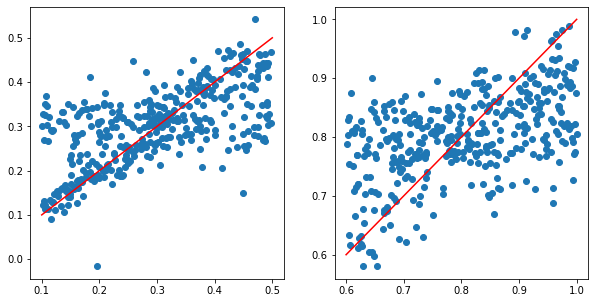

In [11]:
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000]]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000]]

y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()


rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.plot(ideal2,ideal2,"r")





y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()


rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.plot(ideal2,ideal2,"r")

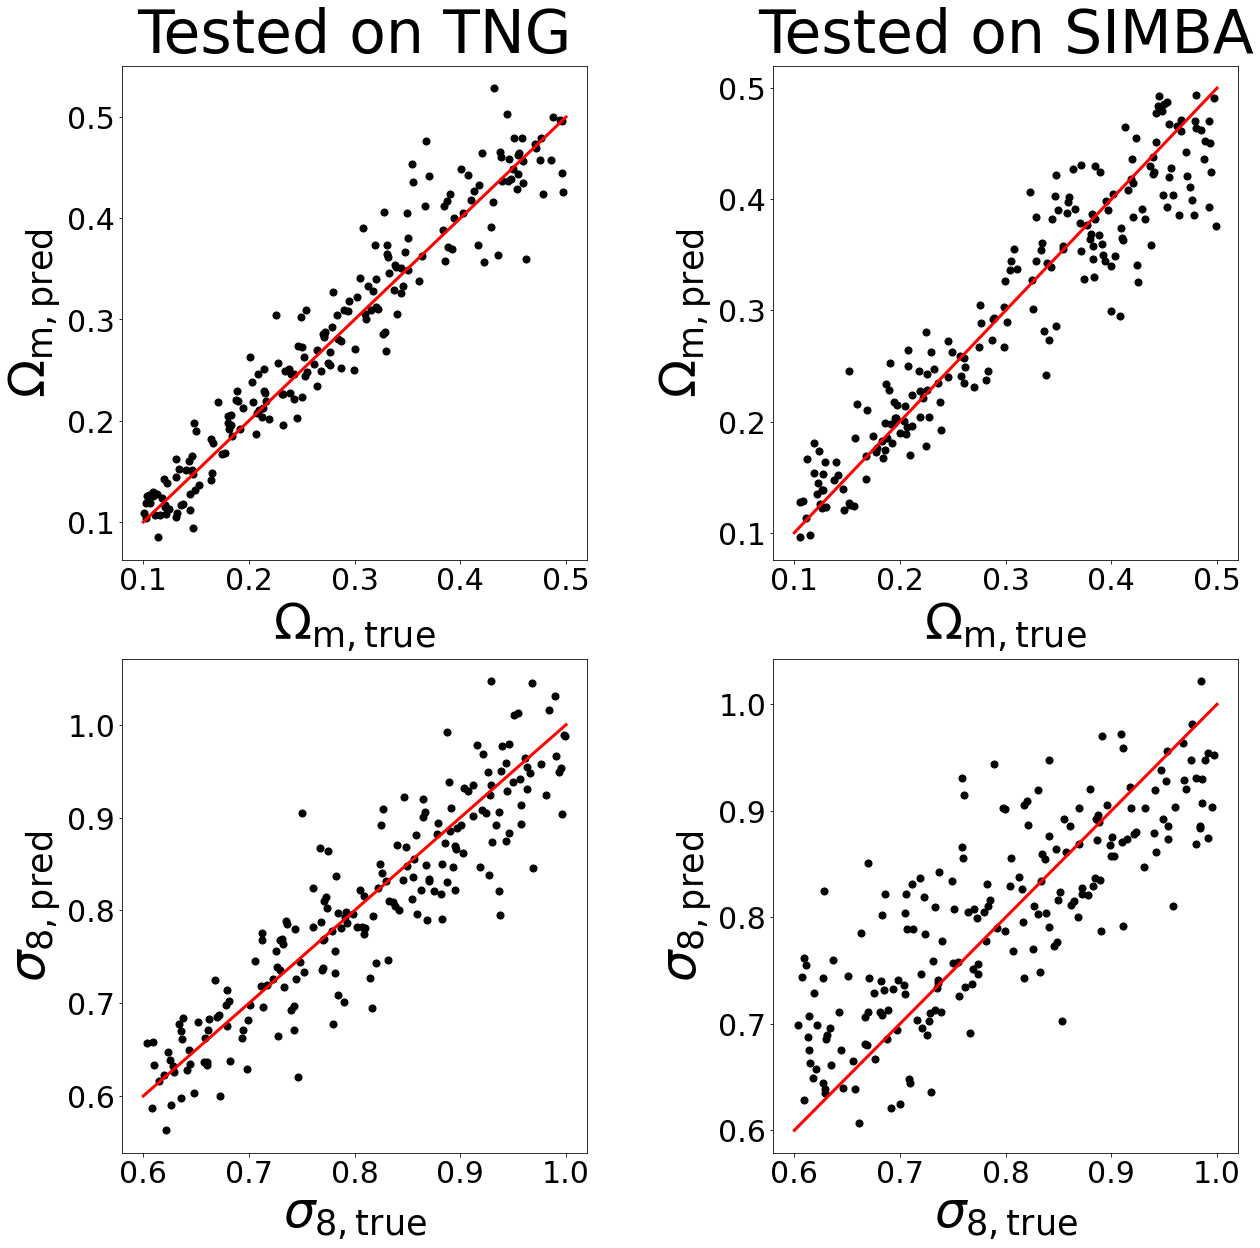

In [10]:
plt.rcParams['font.size'] = '50'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
plt.rcParams['xtick.labelsize'] = '30'
plt.rcParams['ytick.labelsize'] = '30'

fig = plt.figure(figsize=(20,20))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)

fig.add_subplot(2,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.title('Tested on TNG')
fig.add_subplot(2,2,3)
plt.scatter(y_tng[:,1],y_tng_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
#plt.title('TNG')

fig.add_subplot(2,2,2)
plt.scatter(y_sim[:,0],y_sim_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.title('Tested on SIMBA')
fig.add_subplot(2,2,4)
plt.scatter(y_sim[:,1],y_sim_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
#plt.title('SIMBA')

plt.subplots_adjust(hspace=0.2, wspace=0.4)
plt.savefig("TNG_SIMBA_VIB_gas.png", bbox_inches="tight", dpi=300)

tensor(-0.0240)
tensor(-0.0021)
tensor(0.0774) 0.9523383091069222
tensor(0.0357) 0.8877165398274125
tensor(0.0122)
tensor(-0.0167)
tensor(0.0751) 0.9271936072479438
tensor(0.0689) 0.6499110179129299


/tmp/ipykernel_31466/1883523457.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
/tmp/ipykernel_31466/1883523457.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


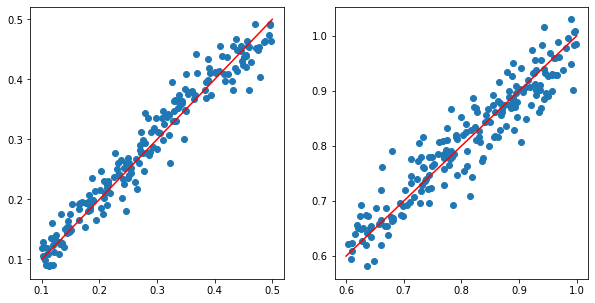

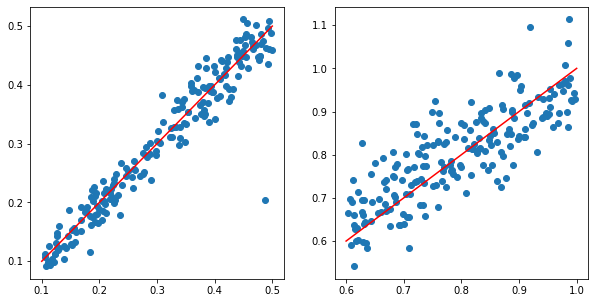

In [14]:
# HI
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000]]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000]]

y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()


rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.plot(ideal2,ideal2,"r")





y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()


rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.plot(ideal2,ideal2,"r")